In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [2]:
from platform import python_version

print(python_version())

3.7.12


In [3]:
# Libraries
import tensorflow as tf
import zipfile
import numpy as np
import random
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
# set the seed and set a path to data folder
SEED = 42
np.random.seed = SEED

UNZIP_PATH = '../input/data-science-bowl-2018/'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
# Unzip data
with zipfile.ZipFile(UNZIP_PATH+'stage1_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./train')
    
with zipfile.ZipFile(UNZIP_PATH+'stage1_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./test')

In [6]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
# define placeholders with numpy array of zeroz
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1),dtype= bool)

In [8]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1),dtype= bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!') 

Resizing training images and masks


100%|██████████| 670/670 [08:02<00:00,  1.39it/s]


Resizing test images


100%|██████████| 65/65 [00:02<00:00, 31.14it/s]

Done!


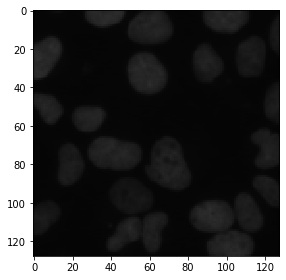

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [16]:

image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(Y_train[image_x])


In [10]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) # normalization

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(s) # start with normal distributed weights
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer = "he_normal", padding = "same")(c9)

outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2022-07-11 13:33:34.781729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 13:33:34.882420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 13:33:34.883191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 13:33:34.884783: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [11]:
# Callbacks
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

2022-07-11 13:33:37.602256: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-07-11 13:33:37.602436: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-07-11 13:33:37.604765: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-07-11 13:33:37.811977: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-07-11 13:33:37.812150: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [12]:
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=16, epochs=25)

2022-07-11 13:33:38.034783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-07-11 13:33:40.297921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


34/34 [==============================] - 10s 48ms/step - loss: 0.5959 - accuracy: 0.7784 - val_loss: 0.5018 - val_accuracy: 0.7785
Epoch 2/25
34/34 [==============================] - 1s 25ms/step - loss: 0.3583 - accuracy: 0.8252 - val_loss: 0.3242 - val_accuracy: 0.8327
Epoch 3/25
34/34 [==============================] - 1s 25ms/step - loss: 0.2072 - accuracy: 0.9148 - val_loss: 0.1987 - val_accuracy: 0.9206
Epoch 4/25
34/34 [==============================] - 1s 30ms/step - loss: 0.1510 - accuracy: 0.9415 - val_loss: 0.1616 - val_accuracy: 0.9339
Epoch 5/25
34/34 [==============================] - 1s 25ms/step - loss: 0.1294 - accuracy: 0.9504 - val_loss: 0.1417 - val_accuracy: 0.9440
Epoch 6/25
34/34 [==============================] - 1s 25ms/step - loss: 0.1236 - accuracy: 0.9528 - val_loss: 0.1309 - val_accuracy: 0.9473
Epoch 7/25
34/34 [==============================] - 1s 25ms/step - loss: 0.1120 - accuracy: 0.9577 - val_loss: 0.1240 - val_accuracy: 0.9512
Epoch 8/25
34/34 [=====

In [13]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 57ms/step


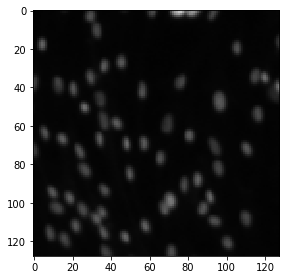

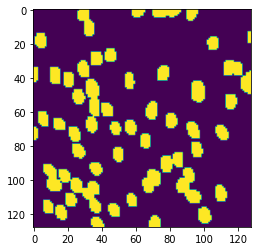

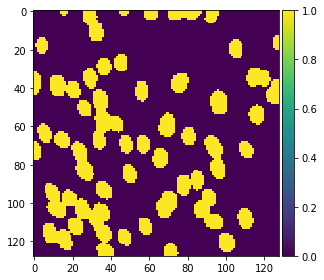

In [14]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
plt.imshow((Y_train[ix]))
plt.show()
imshow((preds_train_t[ix]))
plt.show()

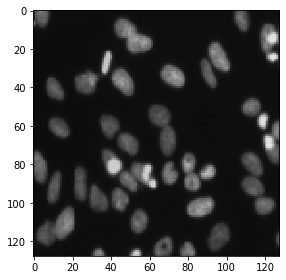

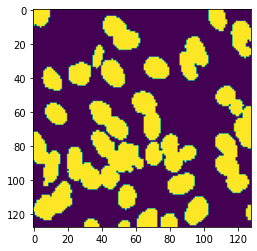

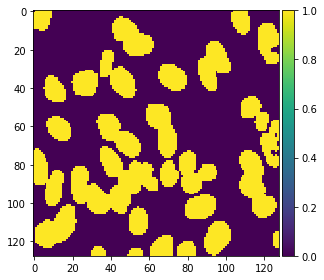

In [15]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
